# Project 3 - Solving Linear PDE's using Physics Informed Neural Network (PINN)
## The differential equations
### Diffusion equation
$$\frac{\partial u}{\partial t} - D\frac{\partial^{2}}{\partial x^{2}} = f(t,x) $$
with $D$ as the diffusion coefficient, and $f(t,x)$ as a generic source function. 

### Burgers equation
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} - \mu\frac{\partial^{2} u}{\partial x^{2}} = f(t,x) $$
Here, $\mu$ denotes the viscosity of the system.

### Wave equation
$$\frac{\partial^{2} u}{\partial t^{2}} - c^{2}\frac{\partial^{2} u}{\partial x^{2}} = f(t,x) $$
with $c$ denoting the wave speed.

## Solutions to PDE's using a PINN
This part solves the equations below using two PINN-implementations.<br />

The first is an implementation uses Autograd's differentiation method...  using a method defining a trial function...<br />

The second implementation uses TensorFlow's Keras-API to build out the network and perform the feed-forward and backpropagation part, and is based on an implementation by ... ([PINNs-TF2](https://github.com/pierremtb/PINNs-TF2.0?tab=readme-ov-file)). This uses...

Based on implementation from ... 

#### Program imports and defaults

In [1]:
from PDEq import *
from support import *
from network import *
from networkFlowTorch import *

from time import time

import autograd.numpy as anp
from autograd import elementwise_grad

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

## Random seed
default_seed = 15; anp.random.seed(default_seed)

## Figure defaults
plt.rcParams["figure.figsize"] = (8,3); plt.rcParams["font.size"] = 10


2024-12-09 14:22:34.118885: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 14:22:34.129981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733750554.142637  130547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733750554.146182  130547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 14:22:34.159026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Problem setup

In [2]:
## Differential equations
test_cases = ['diff1d','burgers1d','wave1d']
test = test_cases[2]

## Coefficients
c,D,amplitude = 1.,1.,1.

if test == 'diff1d':
    PDE = Diffusion1D(sim_type='own',amp=amplitude,D=D)
    PDE_tf = Diffusion1D(sim_type='flow',amp=amplitude,D=D)
    t0,tN,x0,xN = 0,1,0,1
elif test == 'burgers1d':
    PDE = Burger1D(sim_type='own')
    PDE_tf = Burger1D(sim_type='flow')
    t0,tN,x0,xN = 0,1,-1,1
elif test == 'wave1d':
    PDE = Wave1D(sim_type='own',amp=amplitude,c=c)
    PDE_tf = Wave1D(sim_type='flow',amp=amplitude,c=c)
    t0,tN,x0,xN = 0,1,-1,1

## Defining the source function (necessary?)
f    = PDE.right_hand_side
f_tf = PDE_tf.right_hand_side

## Domain setup
Nt,Nx = 10,10

t_bound = [t0,tN]
x_bound = [x0,xN]

t = np.linspace(t_bound[0],t_bound[1],Nt)
x = np.linspace(x_bound[0],x_bound[1],Nx)
        
domain_array = np.array([t,x])

2024-12-09 14:22:35.920115: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Network configuration

In [3]:
## Layer configuration
#layer_out_sizes = [20,20,20,20,20,20,1]
layer_out_sizes = [20,20,20,1]

## Activation functions
hidden_func_tf = 'tanh' # sigmoid, relu, elu, leaky_relu, tanh, swish, gelu, hard_sigmoid, exponential
hidden_func = tanh
hidden_der = elementwise_grad(hidden_func,0)

act_funcs_tf = []; act_funcs = []; act_ders = []
for i in range(len(layer_out_sizes)-1):
    act_funcs_tf.append(hidden_func_tf)
    act_funcs.append(hidden_func)
    act_ders.append(hidden_der)

## Output layer activation function set to identity
act_funcs_tf.append(None); 

act_funcs.append(identity); 
output_der = identity #elementwise_grad(act_funcs[-1],0);
act_ders.append(output_der)

## Network setup using the TensorFlow-implementation

In [ ]:
## Gradient descent method, regularizer and learning rate
lmbda_tf = 1e-8
gd_method_tf = 'adam'
eta_tf = 1e-2 # None
tf_epoch = 100

## Collocation tensor parameters
c_points = 100; b_points = 10; i_points = 10

## Network initializtion
TFNetwork = FFNNetworkFlow(layer_output_size=layer_out_sizes,
                           activation_functions=act_funcs_tf,
                           PDE=PDE_tf,
                           source_function=f_tf,
                           domain_array=domain_array,
                           domain=x_bound,
                           gd_method=gd_method_tf,
                           learning_rate=eta_tf)

## Setup of collocation tensor
TFNetwork.collocation_setup(bounds=(x_bound,t_bound), colloc_points=c_points,
                            bound_points=b_points, init_points=i_points)
TFNetwork.create_layers(lmbda=lmbda_tf)

### Network setup using `FFNNetwork`-class

In [5]:
## Gradient descent method, regularizer and learning rate
eta = [eta_tf if eta_tf is not None else 1e-4]
lmbda = lmbda_tf
epoch = tf_epoch #100
gd_method = ADAM(learning_rate=eta,lmbda=lmbda)

## Network initializtion
OwnNetwork = FFNNetwork(layer_output_size=layer_out_sizes,
                        activation_functions=act_funcs,
                        activation_derivatives=act_ders,
                        PDE=PDE,
                        source_function=f,
                        domain_array=domain_array,
                        domain=x_bound,
                        random_state=default_seed)

### Training the networks

In [6]:
epoch = epoch
tf_epoch = tf_epoch

own_net_timer = [time()]
P = OwnNetwork.train_network(GDMethod=gd_method,epochs=epoch)
own_net_timer.append(time())


tf_net_timer = [time()]
TFNetwork.train_network(epochs=tf_epoch)
tf_net_timer.append(time())

print('Plain PINN-solver time     : %.2f sec.' %(own_net_timer[1]-own_net_timer[0]))
print('TensorFlow PINN-solver time: %.2f sec.' %(tf_net_timer[1]-tf_net_timer[0]))

Initial cost: 1.79113e+02
Epoch 0: Current cost: 1.47107e+02
Epoch 10: Current cost: 6.40025e+01
Epoch 20: Current cost: 4.74310e+01
Epoch 30: Current cost: 4.02864e+01
Epoch 40: Current cost: 3.58946e+01
Epoch 50: Current cost: 3.40877e+01
Epoch 60: Current cost: 3.25401e+01
Epoch 70: Current cost: 3.20667e+01
Epoch 80: Current cost: 3.17660e+01
Epoch 90: Current cost: 3.13847e+01
Final cost: 3.10494e+01
Iteration: 0: Cost = 7.88468e-01
Iteration: 10: Cost = 3.99518e-01
Iteration: 20: Cost = 1.61481e-01
Iteration: 30: Cost = 5.87168e-02
Iteration: 40: Cost = 2.68364e-02
Iteration: 50: Cost = 2.05399e-02
Iteration: 60: Cost = 1.07156e-02
Iteration: 70: Cost = 8.97662e-03
Iteration: 80: Cost = 7.45999e-03
Iteration: 90: Cost = 7.08284e-03
Final cost = 6.89460e-03
Plain PINN-solver time     : 140.29 sec.
TensorFlow PINN-solver time: 2.92 sec.


### Plotting results from networks
#### Plain implementation

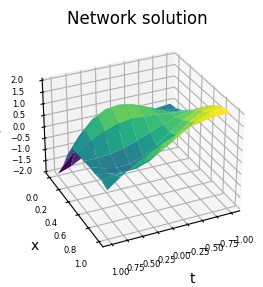

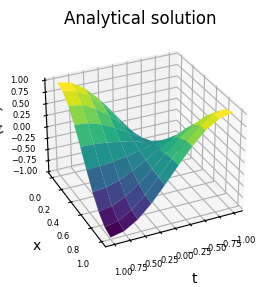

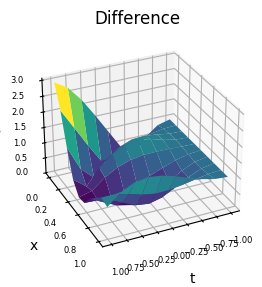

In [7]:
f_names = [str(test)+'_own_network.png',str(test)+'_analytic.png',str(test)+'_difference.png']
OwnNetwork.plot_result(save=False)

#### TensorFlow implementation

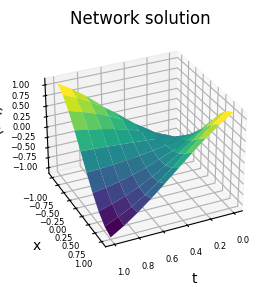

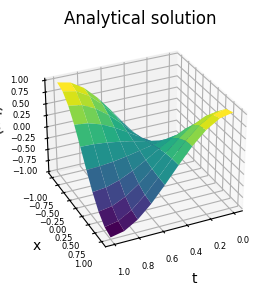

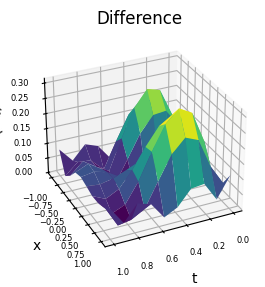

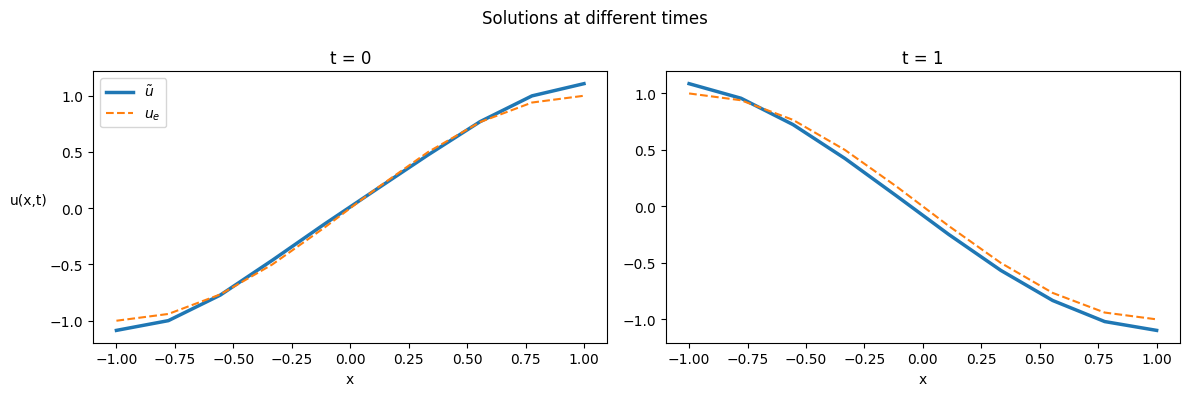

In [8]:
f_names = [str(test)+'_tf_network.png',str(test)+'_analytic.png',str(test)+'_tf_difference.png']
TFNetwork.plot_results(save=False,f_name=f_names)

## Finite difference solutions
This part solves the same PDE's using the _finite difference_ (FD)-method. The implementation is based on classes and methods from the lecture notes and exercises of the UiO-course _MAT-MEK4270 Numerical methods for partial differential equations_ ([MAT-MEK4270](https://matmek-4270.github.io/matmek4270-book/intro.html))

In [11]:
from FiniteDiff import *
import sympy as sp

x_s,t_s = sp.symbols('x, t')

## Domain setup
Nt,Nx = 10,10#Nt,Nx

## Simulation and equation coefficients
cfl = 0.01
c,D,amplitude = 1., D, amplitude

test='wave1d'
if test == 'diff1d':
    x_bound = [0,1]
    bc = {'left': 0, 'right': 0}
    L = x_bound[1] + np.abs(x_bound[0])
    u0 = amplitude * sp.sin(sp.pi*x_s/L)
    fd_solver = Diffusion1DSolver(N=Nx,domain=x_bound,cfl=cfl,u0=u0,D=D)
    
elif test == 'wave1d':
    x_bound = [-1,1]
    bc = {'left': 0, 'right': 0}
    L = x_bound[1] + np.abs(x_bound[0])
    u0 = amplitude * sp.sin(sp.pi*x_s/L)
    fd_solver = Wave1DSolver(N=Nx,domain=x_bound,cfl=cfl,u0=u0,amp=amplitude,c=c)


### Solving the equations with the FD-method

In [12]:
fd_timer = [time()]
fd_solver.solver(tN=t_bound[1],cfl=cfl,bc=bc,ic=0)
fd_solver.solver(tN=1,cfl=cfl,bc=bc,ic=0)

fd_timer.append(time())

print('FD-solver time: %.2f sec.' %(fd_timer[1]-fd_timer[0]))

FD-solver time: 4.56 sec.


### Plotting FD - results

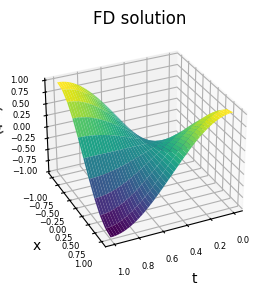

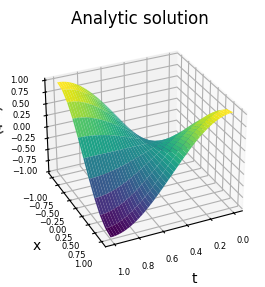

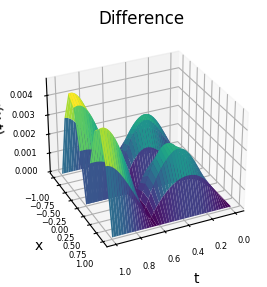

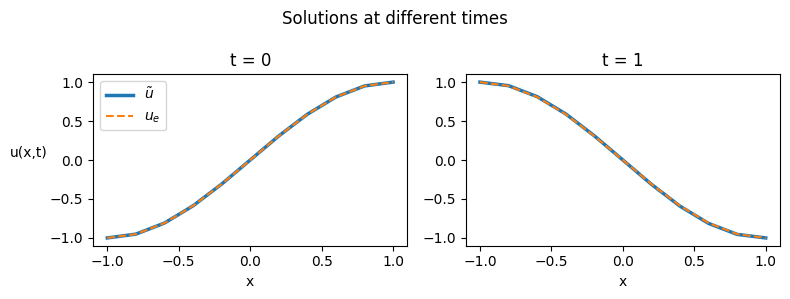

In [13]:
f_names = [str(test)+'_fd_solution.png',str(test)+'_analytic.png',str(test)+'_fd_difference.png']
fd_solver.plot_result(tN=t_bound[1],save=False,f_name=f_names)

### Comparison between the PINN and FD-methods